In [3]:
import tweepy
from textblob  import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import preprocessor as p
import nltk
from datetime import datetime, date, timedelta
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import matplotlib.pyplot as plt

log = pd.read_csv("./config/login.csv")
consumerKey         = log['consumerKey'][0]
consumerSecret      = log['consumerSecret'][0]
accessToken         = log['accessToken'][0]
accessTokenSecret   = log['accessTokenSecret'][0]

auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)
print("----------------access to tweeter api done")

----------------access to tweeter api done


In [4]:
# Generate list of dates (7 days window) based on today's date
print("Get the assigned data from tweeter")
list_of_dates = []
today = date.today()
for i in range(-7,1):
    target_date = (today + timedelta(days=i)).strftime("%Y-%m-%d")
    list_of_dates.append(target_date)

list_of_dicts = []
search_term = 'covid19 covid vaccine'
num_tweets = 100

for end_date in list_of_dates:
    start_date = (datetime.strptime(end_date, '%Y-%m-%d') - timedelta(days=1)).strftime(
        "%Y-%m-%d")  # Create 1-day windows for extraction
    tweet_count = len(list_of_dicts)

    for tweet in tweepy.Cursor(api.search_tweets,
                               q=f'{search_term} since:{start_date} until:{end_date}',
                               lang='en',
                               count=num_tweets,
                               tweet_mode='extended').items(num_tweets):
        if (not tweet.retweeted) and ('RT @' not in tweet.full_text):
            if tweet.lang == "en":
                tweet_dict = {}
                # nltk.download('vader_lexicon')
                # sid = SentimentIntensityAnalyzer()
                # score = sid.polarity_scores(tweet.full_text)
                # comp = score['compound']
                # if comp >= 0.05:
                #     tweet_dict['tar'] = 1
                # elif (comp >-0.05) and (comp <0.05):
                #     tweet_dict['tar'] = 0
                # elif comp <= -0.05:
                #     tweet_dict['tar'] = -1

                tweet_dict['username'] = tweet.user.name
                tweet_dict['location'] = tweet.user.location
                tweet_dict['text'] = tweet.full_text.lower()
                # tweet_dict['fav_count'] = tweet.favorite_count
                tweet_dict['hashtags'] = tweet.entities['hashtags']
                tweet_dict['tweet_date'] = tweet.created_at
                list_of_dicts.append(tweet_dict)
                tweet_count += 1

    print(f'Completed extraction for {start_date} to {end_date},extracted tweet count = {tweet_count}.')

tweets_df = pd.DataFrame(list_of_dicts)
tweets_df.sort_values(by='tweet_date').reset_index(drop=True)

# Setup function to extract hashtags text from the raw hashtag dictionaries
def extract_hashtags(hashtag_list):
    s = ""  # Create empty string
    if not hashtag_list:  # If list is empty, return empty string
        return s
    else:
        for dictionary in hashtag_list:
            s += str(dictionary['text'].lower() + ',')  # Create string (lowercase) for each hashtag text
        s = s[:-1]  # Drop last character ','
        return s

# Extract hashtags
tweets_df['hashtags_extracted'] = tweets_df['hashtags'].apply(lambda x: extract_hashtags(x))
tweets_df.drop(columns='hashtags', inplace=True)
print("----------------loading the data done")

Get the assigned data from tweeter
Completed extraction for 2022-04-12 to 2022-04-13,extracted tweet count = 26.
Completed extraction for 2022-04-13 to 2022-04-14,extracted tweet count = 54.
Completed extraction for 2022-04-14 to 2022-04-15,extracted tweet count = 89.
Completed extraction for 2022-04-15 to 2022-04-16,extracted tweet count = 92.
Completed extraction for 2022-04-16 to 2022-04-17,extracted tweet count = 102.
Completed extraction for 2022-04-17 to 2022-04-18,extracted tweet count = 124.
Completed extraction for 2022-04-18 to 2022-04-19,extracted tweet count = 139.
Completed extraction for 2022-04-19 to 2022-04-20,extracted tweet count = 159.
----------------loading the data done


In [49]:
# Clean tweet text with tweet-preprocessor
tweets_df['text_cleaned'] = tweets_df['text'].apply(lambda x: p.clean(x))
# Remove duplicate tweets
tweets_df.drop_duplicates(subset='text_cleaned', keep="first", inplace=True)
# Remove unnecessary characters
# Note: Need to remove % as Stanford CoreNLP annotation encounters error if text contains some of these characters
punct = ['%','.',',', '/', ':', '\\', '&amp;', '&', ';',"\'"]

def remove_punctuations(text):
    for punctuation in punct:
        text = text.replace(punctuation, '')
    return text

tweets_df['text_cleaned'] = tweets_df['text_cleaned'].apply(lambda x: remove_punctuations(x))

# Drop tweets which have empty text field
tweets_df['text_cleaned'].replace('', np.nan, inplace=True)
tweets_df['text_cleaned'].replace(' ', np.nan, inplace=True)
tweets_df.dropna(subset=['text_cleaned'], inplace=True)

tweets_df = tweets_df.reset_index(drop=True)
print("----------------cleaning the data done")
tweets_df

----------------cleaning the data done


,username,location,text,tweet_date,hashtags_extracted,text_cleaned,Subjectivity,Polarity,Analysis
0,Public Health - Seattle & King County,"Seattle & King County, WA","starting friday, april 15th, outlet collection...",2022-04-12 23:58:08+00:00,covid19,starting friday april th outlet collection mal...,0.420833,0.283333,Positive
1,Tian_A1,Everywhere,#pfizer's covid pill paxlovid gets boost in br...,2022-04-12 23:56:05+00:00,"pfizer,covid19,biotech",s covid pill paxlovid gets boost in britain th...,0.272222,-0.035764,Negative
2,Nina Sun,,a case study on why communities need to part o...,2022-04-12 23:36:29+00:00,covid19,a case study on why communities need to part o...,0.000000,0.000000,Neutral
3,Tian_A1,Everywhere,"after initial hiccup, many private hospitals s...",2022-04-12 23:07:06+00:00,"covid19,india,biotech",after initial hiccup many private hospitals st...,0.312500,0.125000,Positive
4,Colorado Department of Public Health & Environ...,Colorado,@cdcgov and cdphe have released covid-19 revac...,2022-04-12 22:45:56+00:00,,and cdphe have released covid-19 revaccination...,0.000000,0.000000,Neutral
...,...,...,...,...,...,...,...,...,...
143,Prairie Mountain Health,"Manitoba, Canada",#carberry covid walk in vaccine clinic on thur...,2022-04-19 22:00:14+00:00,carberry,covid walk in vaccine clinic on thurs april at...,0.000000,0.000000,Neutral
144,YourTV Quinte,"Belleville, Ontario",@bellevilleon mayor @mitchpanciuk highlights i...,2022-04-19 22:00:06+00:00,"covid,viq,bghf,covid19,covidquinte,yourtv,trul...",mayor highlights include vaccine numbers norm ...,0.050000,-0.075000,Negative
145,Bhekisisa,Johannesburg,according to round 4 of the #covid19 democracy...,2022-04-19 22:00:00+00:00,"covid19,bhekisisaresource",according to round of the democracy survey ( +...,0.325000,-0.100000,Negative
146,Wondering,,obama adviser valerie jarrett expressed her to...,2022-04-19 21:58:30+00:00,"covid19,covid_19,masks,vaccines,fauci,biden,ba...",obama adviser valerie jarrett expressed her to...,0.625000,0.250000,Positive


In [6]:
#Write data to local file
print("writting the data into local file.....ing")
# Create timestamp for datetime of extraction
extract_datetime = datetime.today().strftime('%Y%m%d_%H%M%S')

# Create csv filename
filename = 'data/covid_vaccine_tweets_extracted_' + extract_datetime + '.csv'

# Drop duplicates (if any)
tweets_df.drop_duplicates(inplace=True)

# Export dataframe as csv file with above filename
tweets_df.to_csv(filename, index=False)
print("writting the data into local file.....done")

writting the data into local file.....ing
writting the data into local file.....done


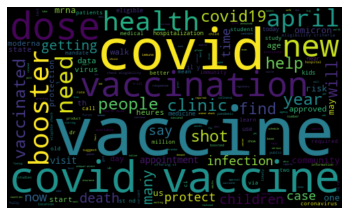

,username,location,text,tweet_date,hashtags_extracted,text_cleaned,Subjectivity,Polarity,Analysis
0,Public Health - Seattle & King County,"Seattle & King County, WA","starting friday, april 15th, outlet collection...",2022-04-12 23:58:08+00:00,covid19,starting friday april th outlet collection mal...,0.420833,0.283333,Positive
1,Tian_A1,Everywhere,#pfizer's covid pill paxlovid gets boost in br...,2022-04-12 23:56:05+00:00,"pfizer,covid19,biotech",s covid pill paxlovid gets boost in britain th...,0.272222,-0.035764,Negative
2,Nina Sun,,a case study on why communities need to part o...,2022-04-12 23:36:29+00:00,covid19,a case study on why communities need to part o...,0.000000,0.000000,Neutral
3,Tian_A1,Everywhere,"after initial hiccup, many private hospitals s...",2022-04-12 23:07:06+00:00,"covid19,india,biotech",after initial hiccup many private hospitals st...,0.312500,0.125000,Positive
4,Colorado Department of Public Health & Environ...,Colorado,@cdcgov and cdphe have released covid-19 revac...,2022-04-12 22:45:56+00:00,,and cdphe have released covid-19 revaccination...,0.000000,0.000000,Neutral
...,...,...,...,...,...,...,...,...,...
143,Prairie Mountain Health,"Manitoba, Canada",#carberry covid walk in vaccine clinic on thur...,2022-04-19 22:00:14+00:00,carberry,covid walk in vaccine clinic on thurs april at...,0.000000,0.000000,Neutral
144,YourTV Quinte,"Belleville, Ontario",@bellevilleon mayor @mitchpanciuk highlights i...,2022-04-19 22:00:06+00:00,"covid,viq,bghf,covid19,covidquinte,yourtv,trul...",mayor highlights include vaccine numbers norm ...,0.050000,-0.075000,Negative
145,Bhekisisa,Johannesburg,according to round 4 of the #covid19 democracy...,2022-04-19 22:00:00+00:00,"covid19,bhekisisaresource",according to round of the democracy survey ( +...,0.325000,-0.100000,Negative
146,Wondering,,obama adviser valerie jarrett expressed her to...,2022-04-19 21:58:30+00:00,"covid19,covid_19,masks,vaccines,fauci,biden,ba...",obama adviser valerie jarrett expressed her to...,0.625000,0.250000,Positive


In [52]:
#Create a function to get the subjectivity and polarity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

#Create two new columns
tweets_df['Subjectivity'] = tweets_df['text_cleaned'].apply(getSubjectivity)
tweets_df['Polarity'] = tweets_df['text_cleaned'].apply(getPolarity)


# Pot the Word Cloud
allWords = ' '.join([twts for twts in tweets_df['text_cleaned']])
wordCould = WordCloud(width=500,height=300,random_state=21,max_font_size=100).generate(allWords)

plt.imshow(wordCould,interpolation="bilinear")
plt.axis('off')
plt.show()

tweets_df

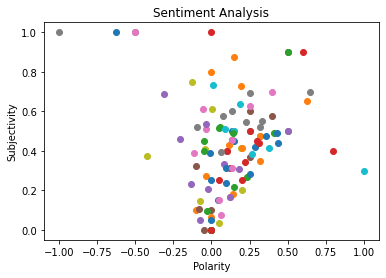

,username,location,text,tweet_date,hashtags_extracted,text_cleaned,Subjectivity,Polarity,Analysis
0,Public Health - Seattle & King County,"Seattle & King County, WA","starting friday, april 15th, outlet collection...",2022-04-12 23:58:08+00:00,covid19,starting friday april th outlet collection mal...,0.420833,0.283333,Positive
1,Tian_A1,Everywhere,#pfizer's covid pill paxlovid gets boost in br...,2022-04-12 23:56:05+00:00,"pfizer,covid19,biotech",s covid pill paxlovid gets boost in britain th...,0.272222,-0.035764,Negative
2,Nina Sun,,a case study on why communities need to part o...,2022-04-12 23:36:29+00:00,covid19,a case study on why communities need to part o...,0.000000,0.000000,Neutral
3,Tian_A1,Everywhere,"after initial hiccup, many private hospitals s...",2022-04-12 23:07:06+00:00,"covid19,india,biotech",after initial hiccup many private hospitals st...,0.312500,0.125000,Positive
4,Colorado Department of Public Health & Environ...,Colorado,@cdcgov and cdphe have released covid-19 revac...,2022-04-12 22:45:56+00:00,,and cdphe have released covid-19 revaccination...,0.000000,0.000000,Neutral
...,...,...,...,...,...,...,...,...,...
143,Prairie Mountain Health,"Manitoba, Canada",#carberry covid walk in vaccine clinic on thur...,2022-04-19 22:00:14+00:00,carberry,covid walk in vaccine clinic on thurs april at...,0.000000,0.000000,Neutral
144,YourTV Quinte,"Belleville, Ontario",@bellevilleon mayor @mitchpanciuk highlights i...,2022-04-19 22:00:06+00:00,"covid,viq,bghf,covid19,covidquinte,yourtv,trul...",mayor highlights include vaccine numbers norm ...,0.050000,-0.075000,Negative
145,Bhekisisa,Johannesburg,according to round 4 of the #covid19 democracy...,2022-04-19 22:00:00+00:00,"covid19,bhekisisaresource",according to round of the democracy survey ( +...,0.325000,-0.100000,Negative
146,Wondering,,obama adviser valerie jarrett expressed her to...,2022-04-19 21:58:30+00:00,"covid19,covid_19,masks,vaccines,fauci,biden,ba...",obama adviser valerie jarrett expressed her to...,0.625000,0.250000,Positive


In [53]:
#Plot the polarity and subjectivity


plt.figure()
for i in range(0,tweets_df.shape[0]):
    plt.scatter(tweets_df['Polarity'][i],tweets_df['Subjectivity'][i])

plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

tweets_df

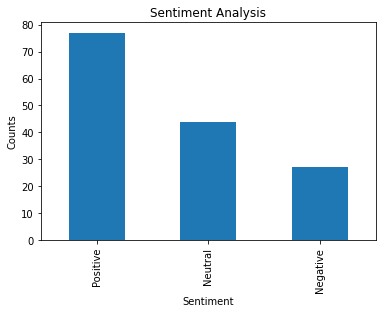

,username,location,text,tweet_date,hashtags_extracted,text_cleaned,Subjectivity,Polarity,Analysis
0,Public Health - Seattle & King County,"Seattle & King County, WA","starting friday, april 15th, outlet collection...",2022-04-12 23:58:08+00:00,covid19,b'starting friday april th outlet collection m...,0.420833,0.283333,Positive
1,Tian_A1,Everywhere,#pfizer's covid pill paxlovid gets boost in br...,2022-04-12 23:56:05+00:00,"pfizer,covid19,biotech",b's covid pill paxlovid gets boost in britain ...,0.272222,-0.035764,Negative
2,Nina Sun,,a case study on why communities need to part o...,2022-04-12 23:36:29+00:00,covid19,b'a case study on why communities need to part...,0.000000,0.000000,Neutral
3,Tian_A1,Everywhere,"after initial hiccup, many private hospitals s...",2022-04-12 23:07:06+00:00,"covid19,india,biotech",b'after initial hiccup many private hospitals ...,0.312500,0.125000,Positive
4,Colorado Department of Public Health & Environ...,Colorado,@cdcgov and cdphe have released covid-19 revac...,2022-04-12 22:45:56+00:00,,b'and cdphe have released covid-19 revaccinati...,0.000000,0.000000,Neutral
...,...,...,...,...,...,...,...,...,...
143,Prairie Mountain Health,"Manitoba, Canada",#carberry covid walk in vaccine clinic on thur...,2022-04-19 22:00:14+00:00,carberry,b'covid walk in vaccine clinic on thurs april ...,0.000000,0.000000,Neutral
144,YourTV Quinte,"Belleville, Ontario",@bellevilleon mayor @mitchpanciuk highlights i...,2022-04-19 22:00:06+00:00,"covid,viq,bghf,covid19,covidquinte,yourtv,trul...",b'mayor highlights include vaccine numbers nor...,0.050000,-0.075000,Negative
145,Bhekisisa,Johannesburg,according to round 4 of the #covid19 democracy...,2022-04-19 22:00:00+00:00,"covid19,bhekisisaresource",b'according to round of the democracy survey (...,0.325000,-0.100000,Negative
146,Wondering,,obama adviser valerie jarrett expressed her to...,2022-04-19 21:58:30+00:00,"covid19,covid_19,masks,vaccines,fauci,biden,ba...",b'obama adviser valerie jarrett expressed her ...,0.625000,0.250000,Positive


In [73]:
#Show the value counts
tweets_df['Analysis'].value_counts()
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
tweets_df['Analysis'].value_counts().plot(kind='bar')
plt.show()

tweets_df

In [111]:
#lstm module
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
train_size = int(len(tweets_df) * .8)

train_cleandText = tweets_df['text_cleaned'][:train_size].fillna("")
test_cleandText = tweets_df['text_cleaned'][train_size:]

#Vectorizing the text
tokenizer = Tokenizer(num_words=2000)

tokenizer.fit_on_texts(train_cleandText)

# X = tokenizer.texts_to_sequences(tweets_df['text_cleaned'].values)
# X = pad_sequences(X)

#parameters for LSTM
# nb_lstm_outputs = 200  #神经元个数
# nb_time_steps = 7  #时间序列长度
# nb_input_vector = 148 #输入序列
# batch_size = 32
#
# model = Sequential()
# #model.add(Embedding(2000, embed_dim,input_length = X.shape[1], dropout = 0.2))
# model.add(LSTM(units=nb_lstm_outputs, input_shape=(nb_time_steps, nb_input_vector)))
# model.add(Dense(10,activation='softmax'))
# model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
# print(model.summary())
#
# Y = pd.get_dummies(tweets_df['Analysis']).values
# X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
# print(X_train.shape,Y_train.shape)
# print(X_test.shape,Y_test.shape)
#model.fit(X_train, Y_train, batch_size = batch_size, nb_epoch = 1, verbose = 2)

TypeError: a bytes-like object is required, not 'dict'